In [1]:
import numpy as np
import os 
import pickle

import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

from architectures.condDCGAN import *

In [2]:
task='TRAIN'
#task='TEST'

PATH='mnist_condDCGAN_test3'
trunc_normal= tf.truncated_normal_initializer(stddev=0.02, seed=SEED)
normal = tf.random_normal_initializer(stddev=0.02, seed=SEED)

In [3]:
if task=='TRAIN' and os.path.exists(PATH+'/hyper_parameters.pkl'):
    with open(PATH+'/hyper_parameters.pkl', 'rb') as f:  
        hyper_dict = pickle.load(f)
        for key, item in hyper_dict.items():
            print(key+':'+str(item))
            
    reco_path = hyper_dict['reco_path']
    true_path = hyper_dict['true_path']
    n_batches = hyper_dict['n_batches']
    test_size = hyper_dict['test_size']
    LEARNING_RATE = hyper_dict['LEARNING_RATE']
    BETA1 = hyper_dict['BETA1']
    BATCH_SIZE = hyper_dict['BATCH_SIZE']
    EPOCHS = hyper_dict['EPOCHS']
    SAVE_SAMPLE_PERIOD = hyper_dict['SAVE_SAMPLE_PERIOD']
    SEED = hyper_dict['SEED']
    d_sizes = hyper_dict['d_sizes']
    g_sizes = hyper_dict['g_sizes']
    preprocess = hyper_dict['preprocess']
    cost_type = hyper_dict['cost_type']
    validating_size=hyper_dict['validating_size']
    discr_steps=hyper_dict['discr_steps']
    gen_steps=hyper_dict['gen_steps']
    
    
    
else:
    
    reco_path = '/disk/lhcb_data/davide/HCAL_project/piplus_cells_inout/piplus/reco/'
    true_path = '/disk/lhcb_data/davide/HCAL_project/piplus_cells_inout/piplus/true_lowdef/'
    n_batches = 10
    test_size = 100
    validating_size=100
    
    LEARNING_RATE = 0.002
    BETA1 = 0.5
    BATCH_SIZE = 32
    EPOCHS = 10
    SAVE_SAMPLE_PERIOD = 500
    SEED = 1
    preprocess=False
    cost_type='GAN'
    discr_steps=1
    gen_steps=4
    
    ndf = 8
    ngf = 16
    stddev_d=0.02
    stddev_g=0.02
    # # Convolutional layers
    s=2
    f=4
        
    d_sizes={
        
         'conv_layers': [
                             (ndf/4,  f, s, False, 0.8, lrelu, tf.truncated_normal_initializer(stddev_d)), #(batch, 52, 64, 2) => (batch, 26, 32, ndf)
                             (ndf*4,    f, s, 'bn', 1, lrelu, tf.truncated_normal_initializer(stddev_d)), #(batch, 26, 32, ndf) => (batch, 13, 16, ndf*2)
                             (ndf*8,  f, s, 'bn', 1, lrelu, tf.truncated_normal_initializer(stddev_d)), #(batch, 13, 16, ndf*2) => (batch, 7, 8, ndf*4)
                             #(ndf*4, 4, s, 'bn', 1, lrelu, tf.truncated_normal_initializer(stddev_d)), #(batch, 7, 8, ndf*8) => (batch, 7, 8, ndf*8)
                             
                        ],
        'dense_layers': [
                         (1024, 'bn',  0.8, lrelu, tf.truncated_normal_initializer(stddev=0.01)),
                         (10,   False,  0.8, lrelu, tf.truncated_normal_initializer(stddev=0.01))
                        ],
        
         'readout_layer_w_init': tf.truncated_normal_initializer(stddev=0.01),
    }
    g_sizes = {
         'z': 256,
         'dense_layers': [
                          #(512, 'bn', 1, tf.nn.relu, tf.truncated_normal_initializer(stddev_g)),
                          (ngf*2, False, 1, tf.nn.relu, tf.truncated_normal_initializer(stddev_g)),
                          (ngf*8, 'bn', 1, tf.nn.relu, tf.truncated_normal_initializer(stddev_g)),
                         ],
         'projection':[(ngf*8,   'bn', 1, tf.nn.relu, tf.truncated_normal_initializer(stddev_g))],
         
         'conv_layers': [(ngf*8,  4, s, 'bn', 1, tf.nn.relu ,tf.glorot_normal_initializer()),
                         (ngf*4,    f, s, 'bn', 1, tf.nn.relu, tf.glorot_normal_initializer()),
                         (ngf/4,  f, s, 'bn',  1 , tf.nn.relu, tf.glorot_normal_initializer()),
                         (1,      f, s, False, 0.5,  tf.nn.sigmoid, tf.glorot_normal_initializer())],
    }


In [4]:
def mnist():
    
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

    X_train = mnist.train.images
    X_test = mnist.test.images
    
    Y_train = mnist.train.labels
    Y_test = mnist.test.labels
    
    
    X_train = X_train.reshape(X_train.shape[0],28,28,1)
    X_test = X_test.reshape(X_test.shape[0],28,28,1)
    
    n_H = X_train.shape[1]
    n_W = X_train.shape[2]
    n_C = X_train.shape[-1]
    
    
    tf.reset_default_graph()
    
    
    gan = condDCGAN(1, n_H, n_W, n_C, d_sizes=d_sizes, g_sizes=g_sizes,
                lr=LEARNING_RATE, beta1=BETA1, preprocess=preprocess,
                cost_type=cost_type,
                discr_steps=discr_steps, gen_steps=gen_steps,
                batch_size=BATCH_SIZE, epochs=EPOCHS,
                save_sample=SAVE_SAMPLE_PERIOD, path=PATH, seed=SEED)
    
    vars_to_train= tf.trainable_variables()
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
        
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
    
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/'+PATH+'.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'.ckpt')
                print('Model restored.')
            
            gan.set_session(sess)
            gan.fit(X_train, Y_train, validating_size)
            
            save_path = saver.save(sess, PATH+'/'+PATH+'.ckpt')
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/'+PATH+'.ckpt')
            print('Model restored.')
            
            gan.set_session(sess) 
            
        done = False
        while not done:
            
            plt.clf
            ans = int(input("Input a digit from 0 to 9\n"))
            ans=np.array(ans).reshape(1,1)
            Z_in = np.random.uniform(-1,1, size=(1, g_sizes['z']))
            
            im = gan.get_sample(Z_in, ans)
            plt.imshow(im.reshape(28,28), cmap='gray')
            plt.show()
            
            
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Convolutional Network architecture detected for discriminator A
Convolutional architecture detected for generator A
Discriminator_A
Convolution
Input for convolution shape  (?, 28, 28, 2)
minibatch features shape (?, 5)
Logits shape (?, 1)
Generator_A
Deconvolution
Input for deconvolution shape (?, 257)
Deconvoluted output shape (?, 28, 28, 1)
Discriminator_A
Convolution
Input for convolution shape  (?, 28, 28, 2)
minibatch features shape (?, 5)
Logits shape (?, 1)
Generator_A
Deconvolution
Input for deconvolution shape (?, 257)
Deconvoluted output shape (?, 28, 28, 1)

 Training...

 ****** 

Training improved DCGAN with a total of 54900 samples distributed in batches of size 32

The learning rate is 0.002, and every 500 epoch a generated sample will be saved to mnist_condDCGAN_test3

 ****** 


KeyboardInterrupt: 

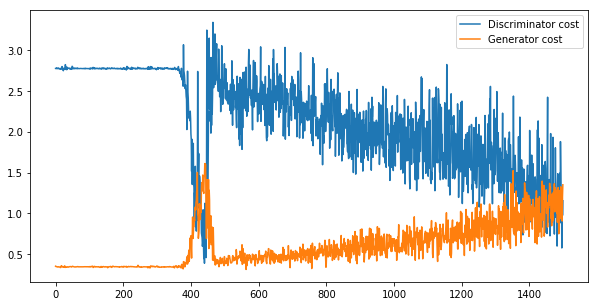

In [5]:
if __name__=='__main__':

    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
    
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)    
        
        mnist()
   
    elif task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            mnist()